# Question 4: Naive Bayes Classifier

Lee Chung Ho 3036030037

In [1]:
import glob
import os
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation

 Import 800 articles about 8 topics and store their contents and labels in 2 lists.

In [2]:
path = r"/Users/dannylee/Desktop/HKU/22-23 SEM2/Data Mining/assignment/Assignment2/Exercise 2/dataset-news"
# path = r"C:\Users\user\Desktop\HKU\22-23 SEM2\Data Mining\assignment\Assignment2\NB\Exercise\dataset-news"

In [3]:
# first sort the result from glob
files = sorted(glob.glob(os.path.join(os.getcwd(), path, "*")))

# Then shuttle the order in a seeded way for repeatable results
random.Random(3603003).shuffle(files)

In [4]:
# extract the contents with file names
data = []
file_name = []

for file in files:
    with open(file) as f_input:
        data.append(f_input.read())
    file_name.append(file)

In [5]:
catagories = ["auto", "baseball", "electronics", "hockey", "ibm-hw", "mac-hw", "moto", "pol-guns"]

label = []

for name in file_name:
    for x in catagories:
        if str(x) in str(name):
            label.append(x)

**Tokenization:**  
Turn all the articles into a vector. Each entry of the vector represents the number of occurrance of a word in the article.  
CountVectorizer returns a matrix: Each row = each document, each column = each word. Then turn into an array type for modeling.  
2 sets of data are generated: one with stop words, and one without stop words

In [6]:
def token(data, remove_stop_words = True):
    if remove_stop_words == True:
        count_vect = CountVectorizer(stop_words="english")
    else:
        count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(data)
    return X_train_counts.toarray()

In [7]:
tokens = token(data)
print(tokens.shape)

(800, 14551)


In [8]:
tokens_ksw = token(data, remove_stop_words = False) #ksw = keep stop words
print(tokens_ksw.shape)

(800, 14842)


There are 14842-14551 = 291 stop words removed from the dataset. Those are words that do not provide much information, such as "a", "an", "the"...

# Modeling

**Types of Naive Bayes Classifier:**  
We are considering 2 types of Naive Bayes Classifiers in this assignment: Gaussian and Multinomial.  
They differ by the way they obtain the posterior probability:  
Gaussian Naive Bayes Classifier is useful when working with continuous values which probabilities can be modeled using a Gaussian (Normal) distribution (a continuous distribution).  
Multinomial Naive Bayes Classifier is useful in modeling discrete data. The posterior probability is modeled from a multinomial distribution (a discrete distribution).   

In [9]:
# split the data into 3:1 for train:test dataset
split = int(0.75*len(tokens))
data_train = tokens[0:split]
data_test = tokens[split:len(tokens)]
label_train = label[0:split]
label_test = label[split:len(tokens)]

In [10]:
gnb = GaussianNB()
gnb.fit(data_train, label_train)

y_pred = gnb.predict(data_test)
print ("Number of mislabeled points out of a total %d points : %d" % \
(data_test.shape[0],(label_test != y_pred).sum()))
print (f"The test accuracy of the Gaussian Naive Bayes model is {1-(label_test != y_pred).sum()/data_test.shape[0]}")

Number of mislabeled points out of a total 200 points : 63
The test accuracy of the Gaussian Naive Bayes model is 0.685


In [11]:
#used when all features follow a multinomial distribution
mnb = MultinomialNB(alpha=1.0) 
mnb.fit (data_train, label_train) 

y_pred = mnb.predict(data_test)
print ("Number of mislabeled points out of a total %d points : %d" % \
(data_test.shape[0],(label_test != y_pred).sum()))
print (f"The test accuracy of the Multinomial Naive Bayes model is {1-(label_test != y_pred).sum()/data_test.shape[0]}")

Number of mislabeled points out of a total 200 points : 43
The test accuracy of the Multinomial Naive Bayes model is 0.785


MultinomialNB seems to perform better than GaussianNB on our dataset. But our dataset might be too small that the models may not have enough information to learn. To further compare the models, we can apply K-fold cross validation.

# K-fold Cross Validation

In K-fold Cross Validation, the dataset is equally divided in k portions. Then we train the model with (k-1) portions of data and test with the remaining portion. Repeat such process for k times.  
It ensures that every observation from the original dataset has the chance of appearing in training and test set, i.e., more information can be learnt by the models.  
10-fold Cross Validation is used in this assignment.

In [12]:
kf = KFold(n_splits=10, shuffle = True, random_state=3603003)

Gaussian = []
for train, test in kf.split(tokens):
    data_train = tokens[train]
    data_test = tokens[test]
    label_train = np.asarray(label)[train]
    label_test = np.asarray(label)[test]
    gnb = GaussianNB()
    gnb.fit(data_train, label_train)
    y_pred = gnb.predict(data_test)
    accuracy = 1-(label_test != y_pred).sum()/data_test.shape[0]
    Gaussian.append(accuracy)

print(f"The test accuracy of the 10 trained Gaussian Naive Bayes models are {Gaussian}")
print(f"The average accuracy of Gaussian Naive Bayes model is {np.mean(Gaussian)}")

The test accuracy of the 10 trained Gaussian Naive Bayes models are [0.675, 0.7, 0.75, 0.8125, 0.75, 0.7125, 0.8125, 0.675, 0.7, 0.8125]
The average accuracy of Gaussian Naive Bayes model is 0.74


In [13]:
kf = KFold(n_splits=10, shuffle = True, random_state=3603003)

Multinomial = []
for train, test in kf.split(tokens):
    data_train = tokens[train]
    data_test = tokens[test]
    label_train = np.asarray(label)[train]
    label_test = np.asarray(label)[test]
    mnb = MultinomialNB(alpha=1.0) 
    mnb.fit (data_train, label_train) 
    y_pred = mnb.predict(data_test)
    accuracy = 1-(label_test != y_pred).sum()/data_test.shape[0]
    Multinomial.append(accuracy)

print(f"The test accuracy of the 10 trained Multinomial Naive Bayes models are {Multinomial}")
print(f"The average accuracy of Multinomial Naive Bayes model is {np.mean(Multinomial)}")

The test accuracy of the 10 trained Multinomial Naive Bayes models are [0.7, 0.7375, 0.7375, 0.825, 0.8625, 0.8125, 0.8, 0.725, 0.8125, 0.8375]
The average accuracy of Multinomial Naive Bayes model is 0.785


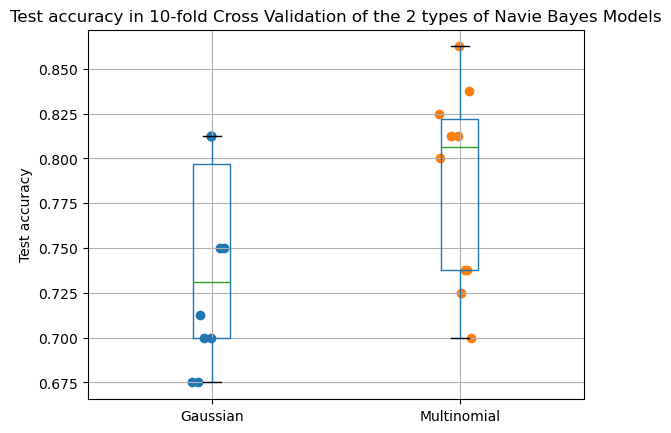

In [14]:
accuracy = pd.DataFrame({"Gaussian": Gaussian, "Multinomial": Multinomial})
accuracy.boxplot()
for i, d in enumerate(accuracy):
   y = accuracy[d]
   x = np.random.normal(i + 1, 0.04, len(y))
   plt.scatter(x, y)
plt.title("Test accuracy in 10-fold Cross Validation of the 2 types of Navie Bayes Models")
plt.ylabel("Test accuracy")
plt.show()

**Question 4 (a)**  
Observed from the box plot, the test accuracy of Multinomial Naive Bayes model is generally higher than the Gaussian Naive Bayes models on our dataset. And its average accuracy is also higher.  
The reason is that, in processing word frequencies, the data are discrete data. The matrix is a sparse matrix where most of the entries are zero. As mentioned above, Guassian Naive Bayes "approximates" the attributes distribution by a normal distribution and find the probability from it. That means it assumes the "class-specific" attribute distribution is normal. However,  
1. Attributes in our dataset are word frequencies. They are not continuous.  
2. Class-specific Attribute distribution is not in normal distribution.  
  
This may be the reason why Gussian Naive Bayes underperforms in this kind of prediction task.   
While Multinomial Naive Bayes Classifier is designed for modeling discrete data, it is more suitable for our dataset

**Random Classifier:**  
To compare the best model with a random classifier, let's build a random classifier. It assigns to each document one of the eight topics, chosen randomly.

In [15]:
def random_classifier(data):
    prediction = []
    catagories = ["auto", "baseball", "electronics", "hockey", "ibm-hw", "mac-hw", "moto", "pol-guns"]
    np.random.seed(seed=3603003)
    random_list = np.random.randint(1,8, size=len(data))
    for i in range(len(data)):
        random_num = random_list[i]
        pred = catagories[random_num]
        prediction.append(pred)
    return prediction

In [16]:
kf = KFold(n_splits=10, shuffle = True, random_state=3603003)

Random = []
for train, test in kf.split(tokens):
    data_train = tokens[train]
    data_test = tokens[test]
    label_train = np.asarray(label)[train]
    label_test = np.asarray(label)[test] 
    y_pred = random_classifier(data_test)
    accuracy = round(1-(label_test != y_pred).sum()/data_test.shape[0],3)
    Random.append(accuracy)

print(f"The test accuracy of the 10 random classifier are {Random}")
print(f"The average accuracy of random classifier is {round(np.mean(Random),3)}")

The test accuracy of the 10 random classifier are [0.162, 0.1, 0.113, 0.162, 0.137, 0.15, 0.162, 0.088, 0.113, 0.05]
The average accuracy of random classifier is 0.124


**Question 4 (b)**  
The average accuracy of random classifier is close to 1/8, i.e. the probability that a document is classied correctly is inversely proporational to the size of the unique topics of the document.  
The average accuracy of Multinomial Naive Bayes model is 0.785, which ~6.3 times the accuracy of the random classifier. This shows the Multinomial Naive Bayes model is powerful in this kind of prediction tasks.

**Keep the stop words:**  
Now we try to train a Multinomial Naive Bayes model using the dataset in which stop word are kept.

In [17]:
kf = KFold(n_splits=10, shuffle = True, random_state=3603003)

Multinomial_ksw = []
for train, test in kf.split(tokens_ksw):
    data_train = tokens_ksw[train]
    data_test = tokens_ksw[test]
    label_train = np.asarray(label)[train]
    label_test = np.asarray(label)[test]
    mnb = MultinomialNB(alpha=1.0) 
    mnb.fit (data_train, label_train) 
    y_pred = mnb.predict(data_test)
    accuracy = 1-(label_test != y_pred).sum()/data_test.shape[0]
    Multinomial_ksw.append(accuracy)

print(f"The test accuracy of the 10 trained Multinomial Naive Bayes models on the stop-word-keeping dataset are {Multinomial_ksw}")
print(f"The average accuracy of Multinomial Naive Bayes model on the stop-word-keeping dataset is {np.mean(Multinomial_ksw)}")

The test accuracy of the 10 trained Multinomial Naive Bayes models on the stop-word-keeping dataset are [0.6875, 0.7375, 0.675, 0.8, 0.825, 0.725, 0.775, 0.6875, 0.725, 0.7625]
The average accuracy of Multinomial Naive Bayes model on the stop-word-keeping dataset is 0.74


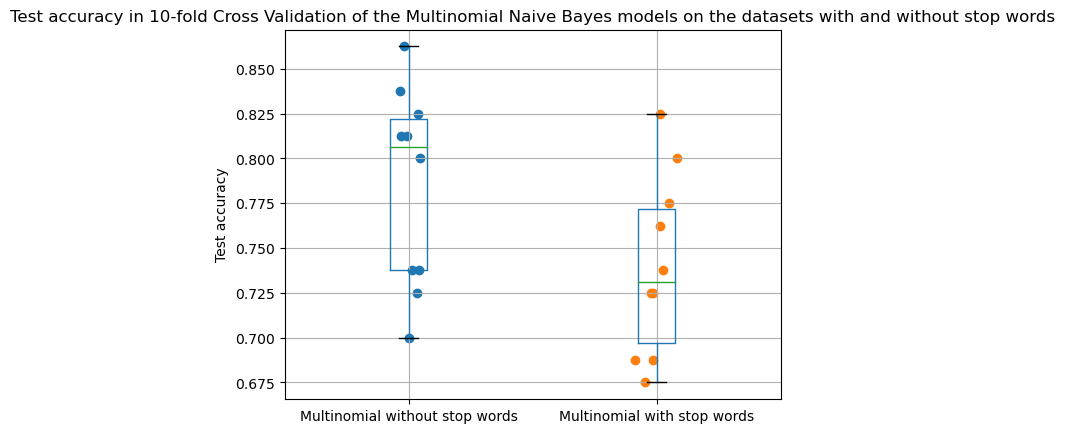

In [18]:
plt.close('all')
accuracy_kws = pd.DataFrame({"Multinomial without stop words": Multinomial, "Multinomial with stop words": Multinomial_ksw})
accuracy_kws.boxplot()
for i, d in enumerate(accuracy_kws):
   y = accuracy_kws[d]
   x = np.random.normal(i + 1, 0.04, len(y))
   plt.scatter(x, y)
plt.title("Test accuracy in 10-fold Cross Validation of the Multinomial Naive Bayes models on the datasets with and without stop words")
plt.ylabel("Test accuracy")
plt.show()

**Question 4 (c)**  
If we keep the stop words, the average accuracy is lower (0.74) compared to removing them (0.785).  
This is mainly because the stop words does not provide much information as they could exist in documents in any topics. It provides no value in the prediction task, but adding noise to the dataset.

**Classification tasks on different catagory of topics:**  
In the first task, you should consider only the documents related to the following topics: "use of guns","hockey","Mac hardware",  
while in the second task you should consider "Mac hardware","IBM hardware" and "electronics".

In [19]:
catagory_1 = ["hockey", "mac-hw", "pol-guns"]
catagory_2 = ["electronics", "ibm-hw", "mac-hw"]

data_1 = []
data_2 = []
label_1 = []
label_2 = []

for i in range(len(label)):
    if label[i] in catagory_1:
        data_1.append(tokens[i])
        label_1.append(label[i])
    if label[i] in catagory_2:
        data_2.append(tokens[i])
        label_2.append(label[i])

In [20]:
kf = KFold(n_splits=10, shuffle = True, random_state=3603003)

Multinomial_1 = []
for train, test in kf.split(data_1):
    data_train = np.asarray(data_1)[train]
    data_test = np.asarray(data_1)[test]
    label_train = np.asarray(label_1)[train]
    label_test = np.asarray(label_1)[test]
    mnb = MultinomialNB(alpha=1.0) 
    mnb.fit (data_train, label_train) 
    y_pred = mnb.predict(data_test)
    accuracy = round(1-(label_test != y_pred).sum()/data_test.shape[0],3)
    Multinomial_1.append(accuracy)

Multinomial_2 = []
for train, test in kf.split(data_2):
    data_train = np.asarray(data_2)[train]
    data_test = np.asarray(data_2)[test]
    label_train = np.asarray(label_2)[train]
    label_test = np.asarray(label_2)[test]
    mnb = MultinomialNB(alpha=1.0) 
    mnb.fit (data_train, label_train) 
    y_pred = mnb.predict(data_test)
    accuracy = round(1-(label_test != y_pred).sum()/data_test.shape[0],3)
    Multinomial_2.append(accuracy)
    
# print(f"The test accuracy of the 10 trained Multinomial Naive Bayes models on hockey, mac-hw, pol-guns are {Multinomial_1}")
print(f"The average accuracy of Multinomial Naive Bayes model on hockey, mac-hw, pol-guns is {round(np.mean(Multinomial_1),3)}")
# print(f"The test accuracy of the 10 trained Multinomial Naive Bayes models on electronics, ibm-hw, mac-hw are {Multinomial_2}")
print(f"The average accuracy of Multinomial Naive Bayes model on electronics, ibm-hw, mac-hw is {round(np.mean(Multinomial_2),3)}")

The average accuracy of Multinomial Naive Bayes model on hockey, mac-hw, pol-guns is 0.937
The average accuracy of Multinomial Naive Bayes model on electronics, ibm-hw, mac-hw is 0.75


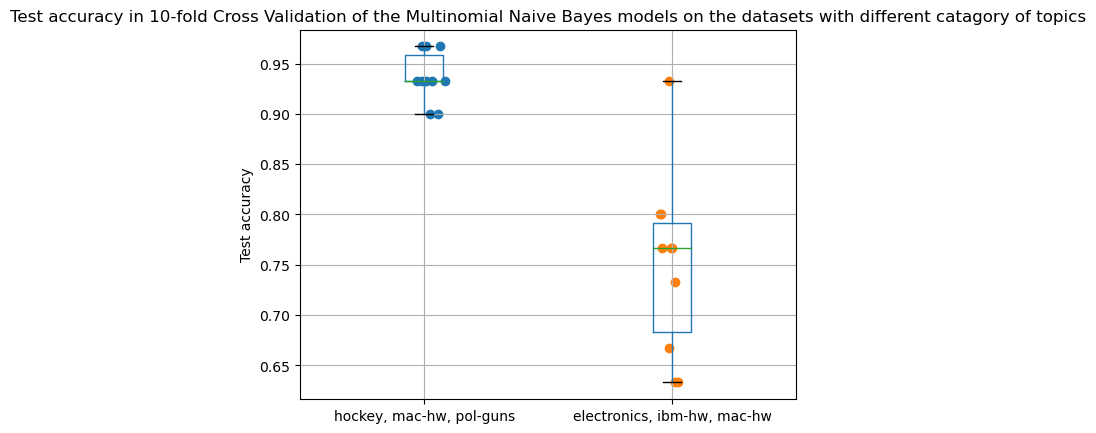

In [21]:
accuracy_catagory = pd.DataFrame({"hockey, mac-hw, pol-guns": Multinomial_1, "electronics, ibm-hw, mac-hw": Multinomial_2})
accuracy_catagory.boxplot()
for i, d in enumerate(accuracy_catagory):
   y = accuracy_catagory[d]
   x = np.random.normal(i + 1, 0.04, len(y))
   plt.scatter(x, y)
plt.title("Test accuracy in 10-fold Cross Validation of the Multinomial Naive Bayes models on the datasets with different catagory of topics")
plt.ylabel("Test accuracy")
plt.show()

**Question 4(d)**  
On average, Multinomial Naive Bayes models on hockey, mac-hw, pol-guns have much higher accuracy (0.937) than that on electronics, ibm-hw, mac-hw (0.75).  
  
This is because electronics, ibm-hw, mac-hw are more related to each other. ibm-hw and mac-hw are electonic products and computer-related. There is a higher probability that same words appear in the documents on these topcs, for example, "CPU", "Chips", "computing speed", "technology"... Therefore, this makes it more difficult to distinguish documents on these 3 topics, resulting in a lower prediction accuracy.     
  
Meanwhile, hockey, mac-hw, pol-guns are not related to each other. Hockey is sports, mac-hw is electroic products, and pol-guns is a political issue. Words appearing in these document can be very different. It help Naive Bayes Model on prediction because Naive Bayes Model computes the posterior probability of each word appearing in a document given a certain topic, i.e, the more specific the occurrance is, the higher the posterior probability, i.e. higher probabiltity that the model classifiy the document with those words into that topic, resuting in a more accurate prediction.